In [213]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
    cross_val_score,
    cross_validate,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    RocCurveDisplay,
    confusion_matrix,
    check_scoring
)

from functools import reduce
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib

In [214]:
# initial dataframe from the cleaned data in silver layer


silver_path = Path.cwd().parent / 'data' / 'silver' / 'creditcard_fraud_cleaned.parquet'

df = pd.read_parquet(silver_path)
print('the shape of this df should be exactly: (283726, 31)\nshape: ', df.shape)
df.head(3)

the shape of this df should be exactly: (283726, 31)
shape:  (283726, 31)


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [215]:
# splitting dataset in X(independent features) and y (target class)

X = df.drop(columns='class')
y = df['class']
(y.value_counts()/y.shape[0])*100

class
0    99.83329
1     0.16671
Name: count, dtype: float64

In [216]:
# all the dataset is already scaled with pca transform, except for time and amount
# so after splitting in training and testing the dataset,let's scale:
# time using minMaxscaler, which is standard
# amount using robustScaler, to better treat the significant rigth skewness and outliers


# Dividir os dados em treino, validação e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=11037)



In [217]:
# Escalando features para treino efetivo dos modelos
time_scaler = MinMaxScaler()
amount_scaler = RobustScaler()

# fit para escalar os dados de treino
X_train['time_scaled'] = time_scaler.fit_transform(X_train[['time']])
X_train['amount_scaled'] = amount_scaler.fit_transform(X_train[['amount']])

# Transform para impedir data leak
X_test['time_scaled'] = time_scaler.transform(X_test[['time']])
X_test['amount_scaled'] = amount_scaler.transform(X_test[['amount']])

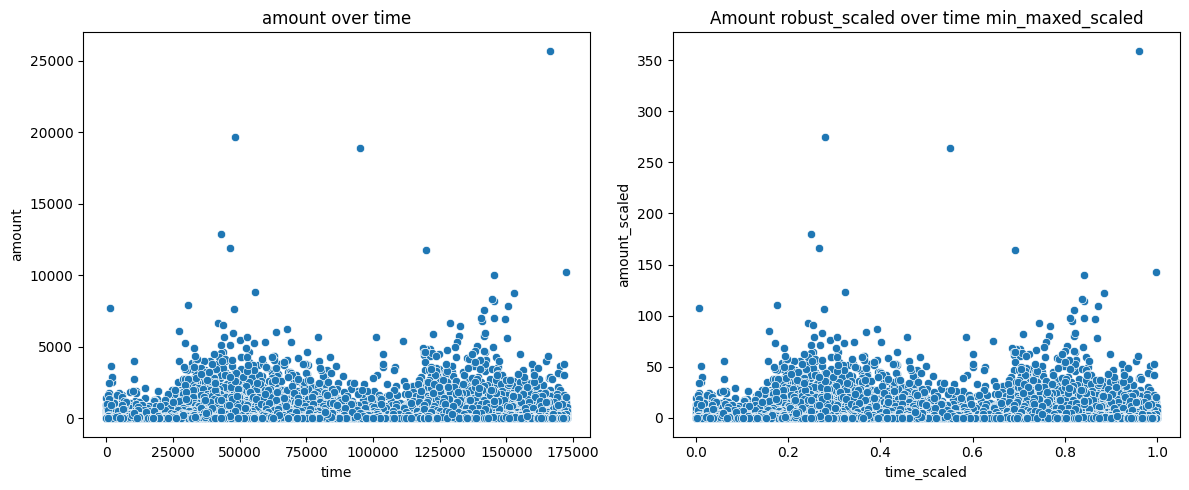

In [221]:
#showing that scalling these features does not lose any information
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# normal time plot
sns.scatterplot(data = X_train, x='time', y='amount', ax=axes[0])
axes[0].set_title('amount over time')

# Right plot
sns.scatterplot(data = X_train, x='time_scaled', y='amount_scaled', ax=axes[1])
axes[1].set_title('Amount robust_scaled over time min_maxed_scaled')


plt.tight_layout()
plt.show()


In [232]:
# preparing the training data (and keeping test data equivalent)
# Retirar colunas não escaladas
X_train = X_train.drop(columns=['time','amount'])
X_test = X_test.drop(columns=['time','amount'])

X_train.head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,time_scaled,amount_scaled
236609,-0.393139,1.189324,-0.972845,-1.014526,1.213519,-0.523921,0.791780,0.371723,-0.420744,-1.485694,...,-0.080817,-0.340053,0.140935,0.147952,-1.001315,-0.905524,0.127762,0.205266,0.863844,-0.168054
174231,2.016173,0.090348,-1.915504,1.082426,0.856750,-0.201241,0.423446,-0.104933,0.082016,0.442963,...,0.062826,0.288314,-0.019187,0.272730,0.468915,-0.514713,-0.030063,-0.070282,0.706755,-0.140208
11595,1.396324,-0.481098,0.630109,-0.244255,-1.082479,-0.782327,-0.685069,-0.214074,0.933545,0.138187,...,-0.179179,-0.205599,-0.014325,0.342026,0.514702,-0.280965,-0.016866,0.005586,0.115246,-0.167914


In [233]:
# lets check the data splitting (this could be a function in the ML pipeline) (still simillar proportion)
print('how many frauds and non frauds in the test split\n',y_test.value_counts())
print()
print((y_test.value_counts()/y_test.shape[0])*100)

how many frauds and non frauds in the test split
 class
0    56651
1       95
Name: count, dtype: int64

class
0    99.832587
1     0.167413
Name: count, dtype: float64


## 🧠 Why Logistic Regression for the Baseline?
Logistic Regression is a simple, interpretable model that gives us a **baseline** for detecting fraud.
It's useful for benchmarking because:

- It requires minimal hyperparameter tuning.
- Its coefficients can indicate feature importance.
- However, **Logistic Regression is sensitive to feature scaling**, so we preprocess `time` and `amount`.

---

## ⚠️ Class Imbalance in Fraud Detection
The dataset is **highly imbalanced**:
- Class 0 (Non-Fraud): 99.833%
- Class 1 (Fraud): 0.167%

This means **accuracy** is a **bad metric** (a model predicting "no fraud" every time would still be right 99.8% of the time). Instead, we use metrics that focus on the minority class.

---

## 📏 Key Metrics for Imbalanced Data
| Metric            | Why It Matters                                                        |
|--------------------|------------------------------------------------------------------------|
| **Precision**      | Of all predicted fraud cases, how many were correct?                 |
| **Recall (Sensitivity)** | Of all actual fraud cases, how many did we detect?                  |
| **F1-score**       | Harmonic mean of Precision and Recall (balances false positives and negatives). |
| **ROC AUC**        | Measures model's ability to separate classes across thresholds.      |
| **PR AUC**         | Precision-Recall AUC focuses on the minority class (more informative for imbalanced data). |
| **Balanced Accuracy** | Adjusts accuracy to account for class imbalance.                  |

We’ll compute all of these using cross validate and stratified k-fold.

In [234]:
# as this is a binary classification problem (it has two classes, positive, fraud, and negative, non-fraud)
# a logistic classifier is more apropriate

log_clf = LogisticRegression(class_weight='balanced',random_state=11037, max_iter=500)

In [235]:
# define scorers
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',  # threshold=0.5
    'recall': 'recall',        # threshold=0.5
    'f1': 'f1',                # threshold=0.5
    'roc_auc': 'roc_auc',      # needs probabilities for it to be based on all threshold
    'pr_auc': 'average_precision',  # needs probabilities
    'balanced_accuracy': 'balanced_accuracy',
}

In [237]:
# define stratified CV to preserve fraud/non-fraud ratio in all folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11037)

In [238]:
# perform cross-validation
cv_results = cross_validate(
    log_clf,
    X_train, y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False,

)
results_df = pd.DataFrame(cv_results).mean()

In [239]:
results_df

fit_time                  1.097999
score_time                0.050846
test_accuracy             0.977738
test_precision            0.064545
test_recall               0.907298
test_f1                   0.120442
test_roc_auc              0.977427
test_pr_auc               0.748303
test_balanced_accuracy    0.942577
dtype: float64

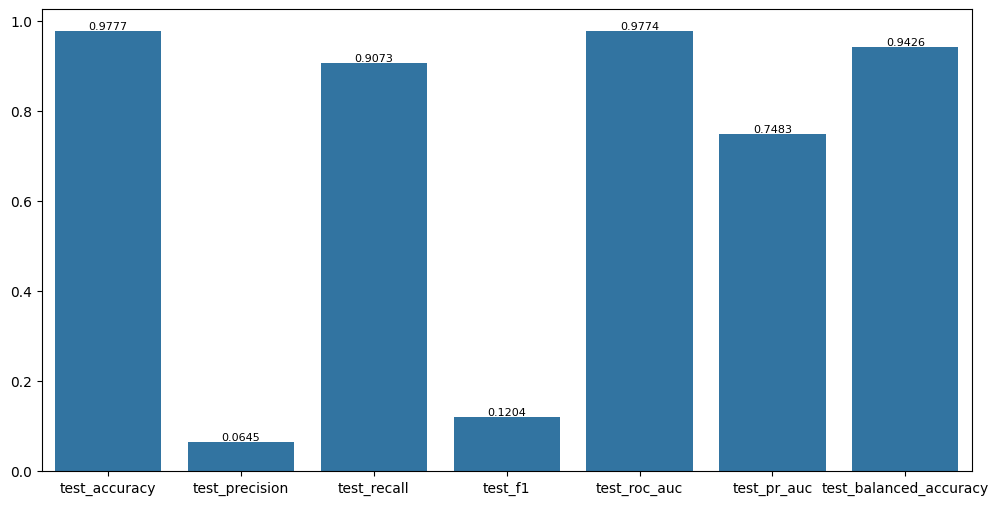

In [240]:
plt.figure(figsize=(12,6))
base_model_scores_barplot = sns.barplot(results_df.loc['test_accuracy':])


for patch in base_model_scores_barplot.patches:
    height = patch.get_height()
    if height > 0:
        base_model_scores_barplot.annotate(f'{height:.4f}',  # formatting
            (patch.get_x() + patch.get_width() / 2, height), # setting each coordinate to be on the patch
            ha='center', va='bottom', fontsize=8, rotation=0) # position related to the patch cordinate, right above and center


plt.show()

In [241]:
log_clf.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,11037
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


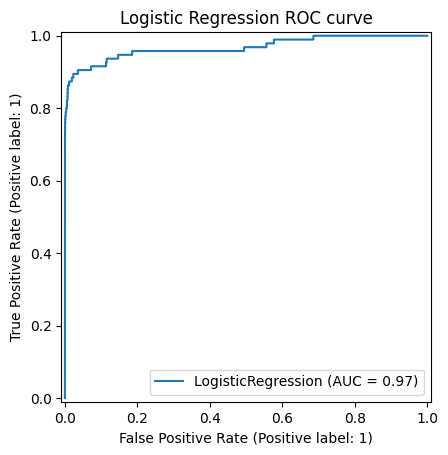

In [242]:
RocCurveDisplay.from_estimator(log_clf, X_test, y_test)
plt.title('Logistic Regression ROC curve')
plt.show()

In [243]:
y_pred_log_clf = log_clf.predict(X_test)

[[55468  1183]
 [   11    84]]


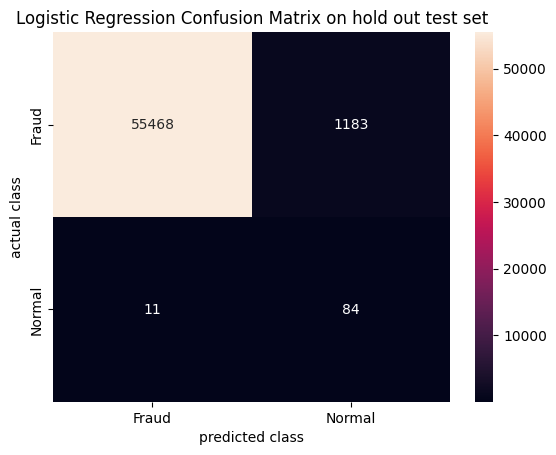

In [244]:
plot_confusion_matrix(y_pred_log_clf, y_test, 'Logistic Regression Confusion Matrix on hold out test set')

In [245]:
# saving the baseline model

file_path = Path.cwd().parent / 'models' / 'logistic_regression_baseline.pkl'
joblib.dump(log_clf, file_path)

print('model succesfully saved in', file_path)

model succesfully saved in e:\Programacao\LAPES\EDA_ML_DL_PS\LAPES-Data-Challenge-Predictive-Analytics-System\models\logistic_regression_baseline.pkl


# Lets remember the features most correlated to target class (fraud)
this will be the base for:

feature selection

feature engineering

feature dropping

In [246]:
# 📊 Correlation with target
correlations = X_train.copy()
correlations['target'] = y_train

corr_matrix = correlations.corr()
target_corr = corr_matrix['target'].drop('target').sort_values(key=abs, ascending=False)

# Display sorted correlations
target_corr


v17             -0.320231
v14             -0.301369
v12             -0.257636
v10             -0.210997
v16             -0.191054
v3              -0.183387
v7              -0.172777
v11              0.153448
v4               0.132418
v18             -0.108265
v9              -0.097115
v1              -0.093504
v5              -0.087988
v2               0.085986
v6              -0.044529
v8               0.035016
v19              0.032730
v21              0.027482
v27              0.025917
v20              0.022778
time_scaled     -0.013937
v28              0.012790
v24             -0.007786
v23             -0.006570
amount_scaled    0.005636
v26              0.005225
v25              0.004712
v13             -0.004201
v22              0.004093
v15             -0.002831
Name: target, dtype: float64

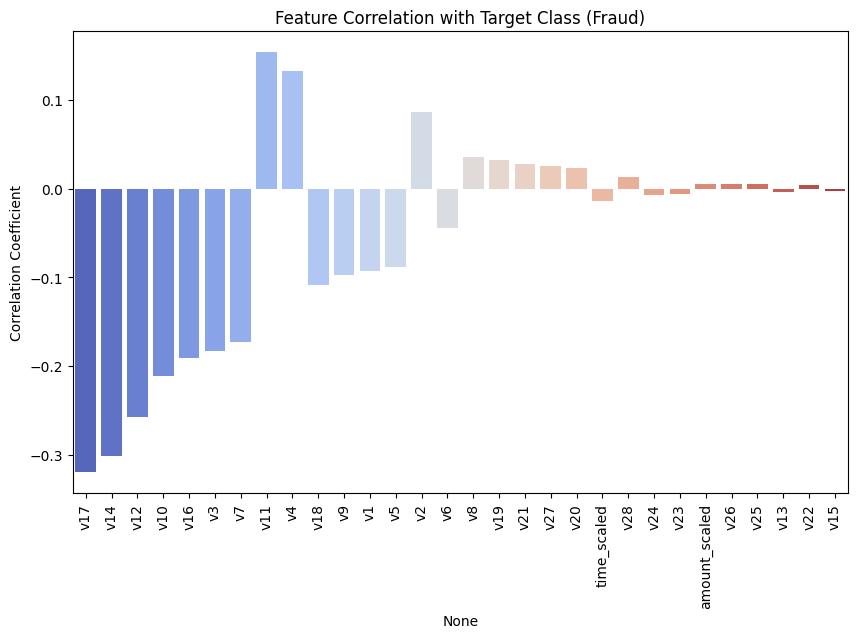

In [247]:
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.index, y=target_corr.values,hue=target_corr.index,legend=False, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Feature Correlation with Target Class (Fraud)")
plt.ylabel("Correlation Coefficient")
plt.show()

In [248]:


used_features = []
scores = []

for f in target_corr.index:
    used_features.append(f)

    log_temp = LogisticRegression(class_weight='balanced', max_iter=400, random_state=11037)

    # 5-fold CV and F1 score (for imbalance)
    cv_scores = cross_val_score(
        log_temp,
        X_train[used_features],
        y_train,
        cv=cv,
        scoring='f1',
        n_jobs=-1
    )

    mean_score = cv_scores.mean()
    scores.append(mean_score)

    print(f"Added Feature: {f} | F1-Score: {mean_score:.4f}")


Added Feature: v17 | F1-Score: 0.6227
Added Feature: v14 | F1-Score: 0.1328
Added Feature: v12 | F1-Score: 0.1191
Added Feature: v10 | F1-Score: 0.1270
Added Feature: v16 | F1-Score: 0.1309
Added Feature: v3 | F1-Score: 0.1261
Added Feature: v7 | F1-Score: 0.1215
Added Feature: v11 | F1-Score: 0.1201
Added Feature: v4 | F1-Score: 0.1171
Added Feature: v18 | F1-Score: 0.1131
Added Feature: v9 | F1-Score: 0.1121
Added Feature: v1 | F1-Score: 0.1097
Added Feature: v5 | F1-Score: 0.1084
Added Feature: v2 | F1-Score: 0.1086
Added Feature: v6 | F1-Score: 0.1091
Added Feature: v8 | F1-Score: 0.1146
Added Feature: v19 | F1-Score: 0.1144
Added Feature: v21 | F1-Score: 0.1139
Added Feature: v27 | F1-Score: 0.1144
Added Feature: v20 | F1-Score: 0.1141
Added Feature: time_scaled | F1-Score: 0.1181
Added Feature: v28 | F1-Score: 0.1184
Added Feature: v24 | F1-Score: 0.1180
Added Feature: v23 | F1-Score: 0.1179
Added Feature: amount_scaled | F1-Score: 0.1198
Added Feature: v26 | F1-Score: 0.1202
Add

## 🔍 Forward Feature Selection with Logistic Regression

To explore the contribution of individual features to model performance, we performed a forward feature selection procedure. At each step, we added the next most-correlated feature to the model and computed the mean F1-score using 5-fold cross-validation.

The results show:

- The first feature alone achieves a very high F1-score (~0.65).
- Adding additional features leads to a sharp performance drop and does not improve results significantly.
- This suggests that the first feature captures most of the fraud signal for a linear model like Logistic Regression.

This behavior is expected because:
- Most features are PCA-transformed and orthogonal, meaning they are uncorrelated by construction.
- Logistic Regression may struggle to separate classes in PCA space.

The plot below illustrates this trend.


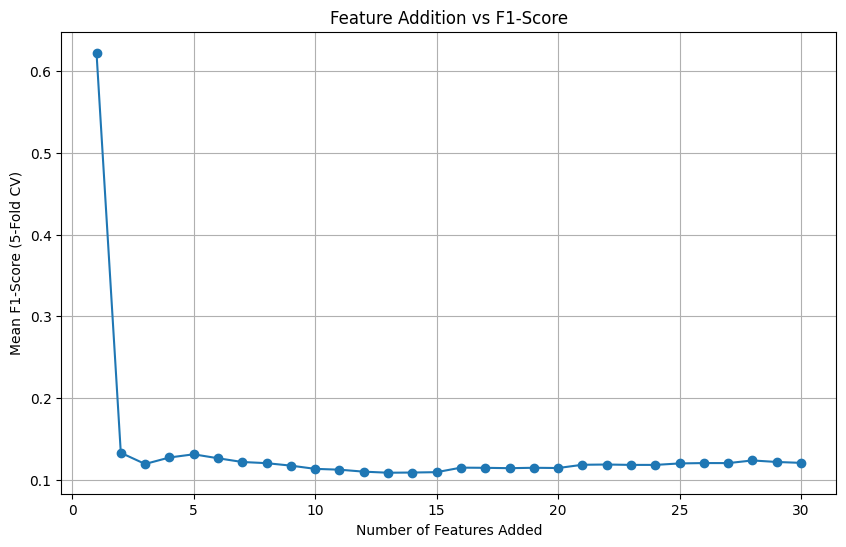

In [249]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o')
plt.title("Feature Addition vs F1-Score")
plt.xlabel("Number of Features Added")
plt.ylabel("Mean F1-Score (5-Fold CV)")
plt.grid(True)
plt.show()

In [250]:
log_v17_clf = LogisticRegression(class_weight='balanced', max_iter=400, random_state=11037)
# perform cross-validation with full metrics on v17 only
cv_v17_results = cross_validate(
    log_v17_clf,
    X_train[['v17']], y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False
)
results_v17_series = pd.DataFrame(cv_v17_results).mean()

In [251]:
def correct_names_after_cv(cv_results_series):
    corrected_names = []
    for index in cv_results_series.index:
        if index.startswith('test_'):
            index = index.removeprefix('test_')
            corrected_names.append(index)
        else:
            corrected_names.append(index)

    cv_results_series.index = corrected_names


In [252]:
correct_names_after_cv(results_v17_series)
results_v17_series

fit_time             0.102093
score_time           0.041037
accuracy             0.998555
precision            0.551049
recall               0.716877
f1                   0.622658
roc_auc              0.803124
pr_auc               0.612341
balanced_accuracy    0.857951
dtype: float64

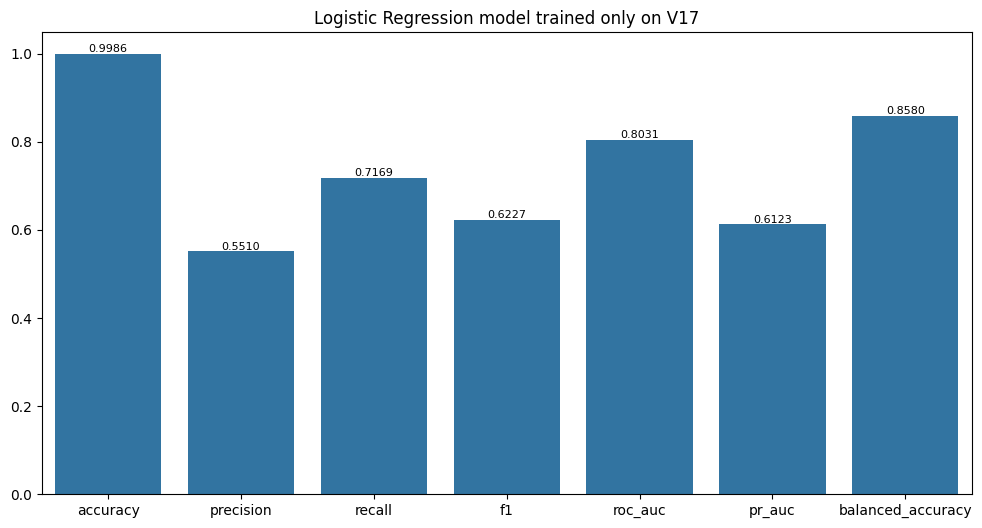

In [253]:
def plot_bar_metrics(score_df: pd.DataFrame, title='placeholder'):
    plt.figure(figsize=(12,6))
    model_scores_barplot = sns.barplot(score_df.loc['accuracy':])


    for patch in model_scores_barplot.patches:
        height = patch.get_height()
        if height > 0:
            model_scores_barplot.annotate(f'{height:.4f}',  # formatting
                (patch.get_x() + patch.get_width() / 2, height), # setting each coordinate to be on the patch
                ha='center', va='bottom', fontsize=8, rotation=0) # position related to the patch cordinate, right above and center

    plt.title(title)
    plt.show()

plot_bar_metrics(results_v17_series, 'Logistic Regression model trained only on V17')

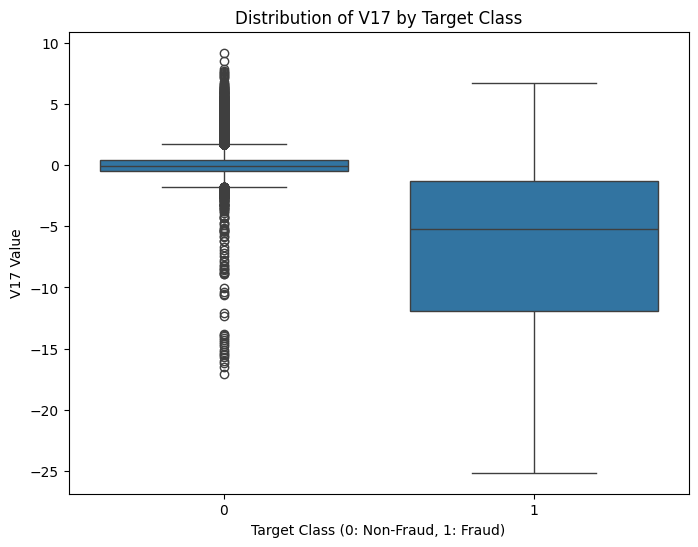

In [254]:


plt.figure(figsize=(8, 6))
sns.boxplot(x=y_train, y=X_train['v17'])
plt.title("Distribution of V17 by Target Class")
plt.xlabel("Target Class (0: Non-Fraud, 1: Fraud)")
plt.ylabel("V17 Value")
plt.show()

In [255]:
# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",  # Binary classification
    eval_metric="aucpr",          # PR AUC for imbalanced data
    scale_pos_weight=10,          # imbalance adjustment
    random_state=11037,
    n_jobs=-1                     # use all cores
)

cv_results = cross_validate(
    xgb_clf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Print mean scores
for metric, scores in cv_results.items():
    if metric.startswith("test_"):
        print(f"{metric}: {scores.mean():.4f}")


test_accuracy: 0.9996
test_precision: 0.9347
test_recall: 0.8149
test_f1: 0.8704
test_roc_auc: 0.9791
test_pr_auc: 0.8520
test_balanced_accuracy: 0.9074


In [ ]:


# Parameter grid
param_dist = {
    'n_estimators': [100, 300, 500, 750],
    'max_depth': [3, 6, 10, None],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6,0.7, 0.8, 1.0],
    'scale_pos_weight': [1, 10, 50]  # imbalance adjustment
}

# Randomized Search
xgb_random = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,                # test 20 random combinations
    scoring='average_precision',  # optimize PR AUC
    cv=cv,                     
    verbose=1,
    random_state=11037,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train )

print("Best parameters found:", xgb_random.best_params_)
print("Best PR AUC score:", xgb_random.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


⚠️ **Note on Hyperparameter Boundaries**
When RandomizedSearchCV selects a parameter at the boundary of the search space, it suggests that a better value may lie beyond the current range. To address this, we expanded the grid for that parameter and reran the search, carefully monitoring for overfitting.


In [ ]:


bst_clf = xgb.XGBClassifier(
    **xgb_random.best_params_,
    random_state=11037,
    n_jobs=-1
)


In [ ]:
bst_clf = bst_clf.fit(X_train,y_train)

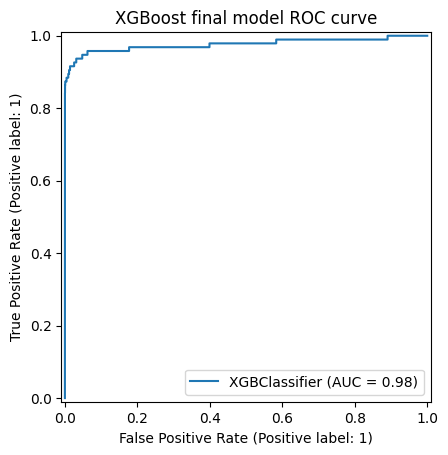

In [ ]:
RocCurveDisplay.from_estimator(bst_clf, X_test, y_test)
plt.title('XGBoost final model ROC curve')
plt.show()v

[[56645     6]
 [   18    77]]


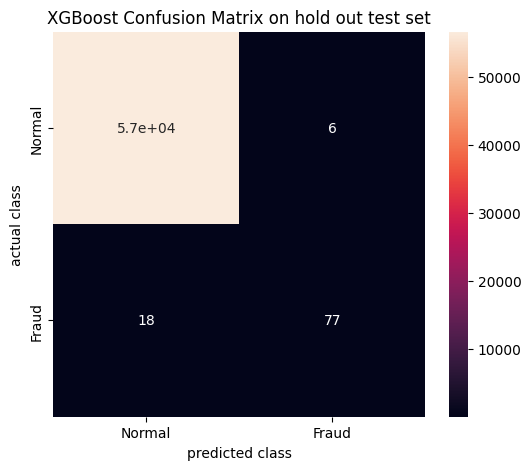

In [ ]:
y_pred_bst_clf = bst_clf.predict(X_test)
final_model_cm = confusion_matrix(y_test,y_pred_bst_clf)

# sns.heatmap(final_model_cm,annot=True)


labels = ['Normal', 'Fraud']
plt.figure(figsize=(6, 5))
ax = sns.heatmap(final_model_cm, annot=True, xticklabels=labels, yticklabels=labels)
plt.title('XGBoost Confusion Matrix on hold out test set')
plt.xlabel('predicted class')
plt.ylabel('actual class')
print(final_model_cm)

In [ ]:
scoring_call = check_scoring(estimator=bst_clf, scoring=scoring, raise_exc=False)
bst_clf_scores = scoring_call(bst_clf, X_test, y_test)

In [ ]:


bst_clf_scores_series = pd.Series(bst_clf_scores)
bst_clf_scores_series

accuracy             0.999577
precision            0.927711
recall               0.810526
f1                   0.865169
roc_auc              0.976215
pr_auc               0.860535
balanced_accuracy    0.905210
dtype: float64

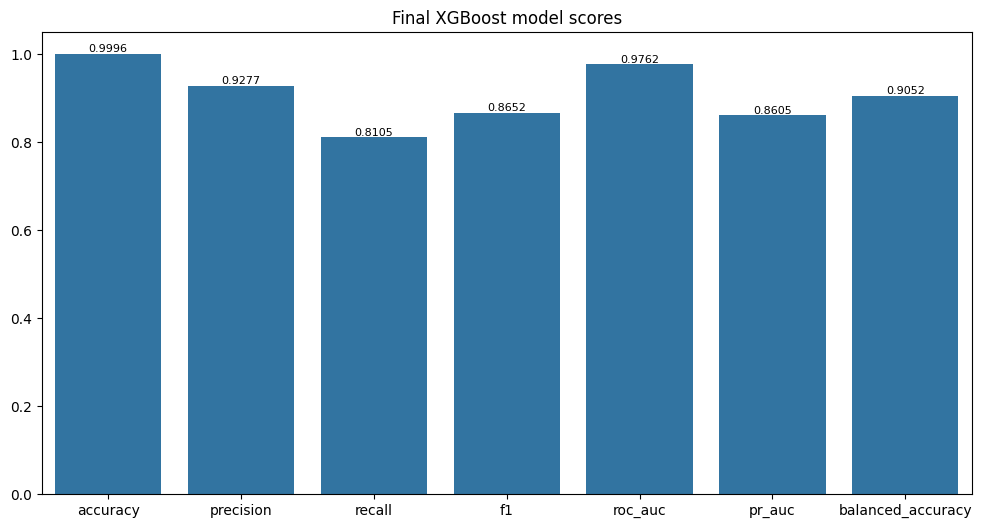

In [ ]:
plot_bar_metrics(bst_clf_scores_series,'Final XGBoost model scores')

In [ ]:
#saving the XGBoost model
file_path = Path.cwd().parent / 'models' / 'final_XGBoost_model.pkl'
joblib.dump(bst_clf, file_path)

print('model succesfully saved in', file_path)

model succesfully saved in e:\Programacao\LAPES\EDA_ML_DL_PS\LAPES-Data-Challenge-Predictive-Analytics-System\models\final_XGBoost_model.pkl


# 🌲 Random Forest Classifier 

To explore non-linear patterns and potential feature interactions, we train a Random Forest Classifier using all PCA-transformed features and the scaled `Amount` and `Time`.  

Random Forest is a tree-based ensemble method that:  
- Handles imbalanced datasets better than linear models.  
- Provides a direct estimate of feature importances.  

We train the model using 5-fold cross-validation and compute the same evaluation metrics as before.


In [ ]:
# ⚙️ Random Forest model
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',  # Handle class imbalance
    random_state=11037,
    n_jobs=-1
)

# 📊 Evaluate model
rf_cv_results = cross_validate(
    rf_clf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# 📄 Display mean CV scores
for metric, scores in rf_cv_results.items():
    if metric.startswith("test_"):
        print(f"{metric}: {scores.mean():.6f}")

results_rand_tree_df = pd.DataFrame(rf_cv_results)


KeyboardInterrupt: 

In [ ]:
results_rand_tree_df = pd.DataFrame(rf_cv_results).mean(numeric_only=True)
results_rand_tree_df.loc['test_accuracy':]

test_accuracy             0.999485
test_precision            0.945307
test_recall               0.732737
test_f1                   0.825389
test_roc_auc              0.938862
test_pr_auc               0.824314
test_balanced_accuracy    0.866333
dtype: float64

In [ ]:
plot_bar_metrics(results_rand_tree_df['test_accuracy':])

NameError: name 'plot_bar_metrics' is not defined

In [ ]:
importances = np.mean(
    [estimator.feature_importances_ for estimator in rf_cv_results['estimator']],
    axis=0
)

# 📊 Sort and display
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
feature_importances

v14              0.170655
v10              0.149109
v12              0.128839
v4               0.106788
v11              0.073921
v17              0.064008
v3               0.035334
v16              0.033381
v7               0.032973
v21              0.020764
v2               0.019689
v19              0.013965
v18              0.013449
amount_scaled    0.012271
v20              0.012179
v8               0.010253
v1               0.009849
v5               0.009664
v13              0.009016
v9               0.008683
v15              0.008311
v26              0.008155
v22              0.007096
v6               0.006623
v27              0.006471
v23              0.006432
v25              0.006126
v28              0.006055
time_scaled      0.005304
v24              0.004639
dtype: float64

C:\Users\José Victor\AppData\Local\Temp\ipykernel_17616\1651492526.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")


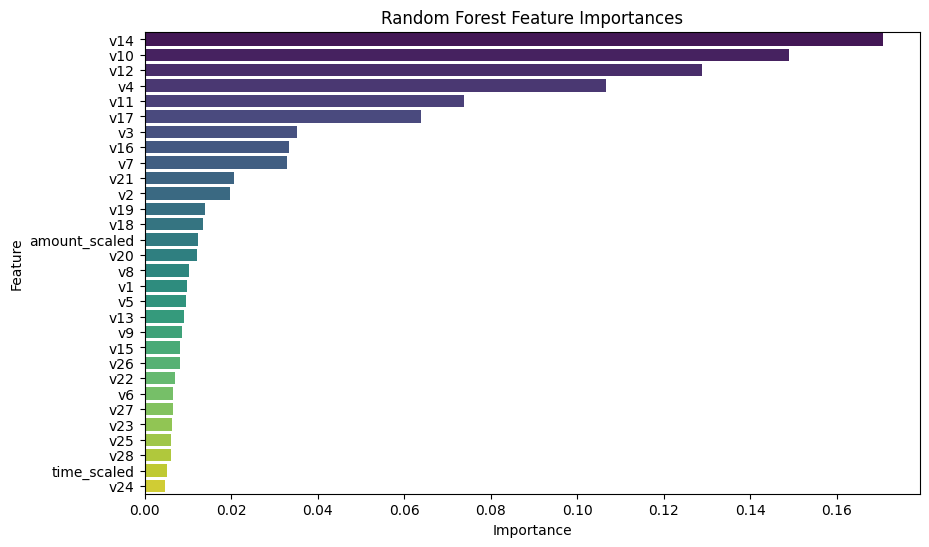

In [ ]:
# 📉 Plot Feature Importances


plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## 🌲 Random Forest Feature Importances

The analysis shows that a small subset of PCA-transformed features (notably V14, V10, V4, V12) carries most of the predictive signal for fraud detection. Features like `amount_scaled` have moderate importance, while `time_scaled` and several PCA features contribute little to model performance.

This suggests that fraud is characterized by patterns concentrated in a few principal components. However, Random Forest’s robustness to irrelevant features allows us to retain all features for now.


In [ ]:
# lets try to speed training up by limiting training to top 5
features_to_use = feature_importances.index[:5]

NameError: name 'feature_importances' is not defined

In [ ]:
# 📊 Evaluate model
rf_quick_cv_results = cross_validate(
    rf_clf,
    X_train[features_to_use],
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# 📄 Display mean CV scores
for metric, scores in rf_quick_cv_results.items():
    if metric.startswith("test_"):
        print(f"{metric}: {scores.mean():.6f}")

results_quick_rand_tree_df = pd.DataFrame(rf_quick_cv_results)


test_accuracy: 0.999454
test_precision: 0.929168
test_recall: 0.727368
test_f1: 0.815330
test_roc_auc: 0.932688
test_pr_auc: 0.802445
test_balanced_accuracy: 0.863638


In [ ]:
results_quick_rand_tree_df = pd.DataFrame(rf_quick_cv_results).mean(numeric_only=True)
results_quick_rand_tree_df.loc['test_accuracy':]

test_accuracy             0.999454
test_precision            0.929168
test_recall               0.727368
test_f1                   0.815330
test_roc_auc              0.932688
test_pr_auc               0.802445
test_balanced_accuracy    0.863638
dtype: float64

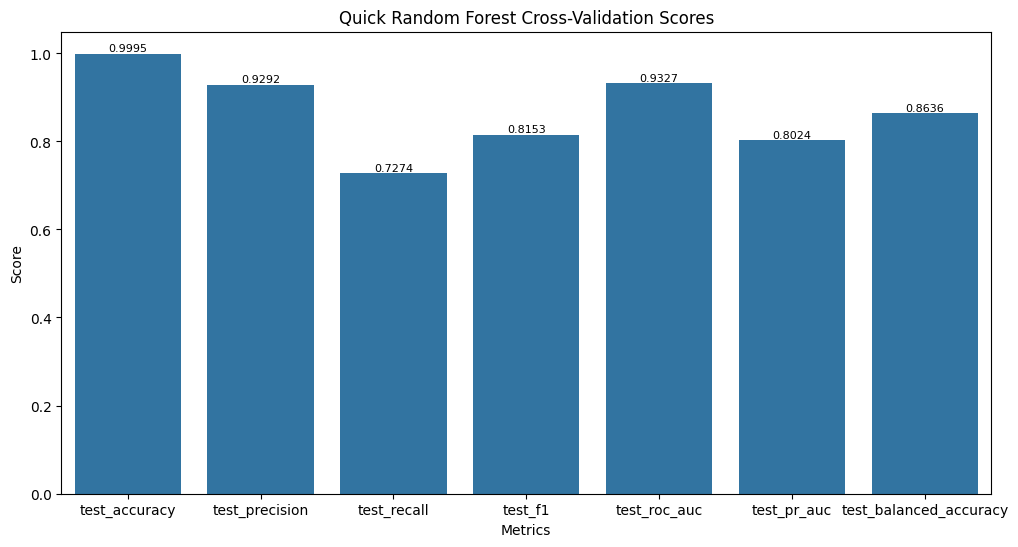

In [ ]:
#plotting the quick version
plt.figure(figsize=(12, 6))

# 📊 Bar plot for Random Forest metrics
quick_rand_tree_scores_barplot = sns.barplot(data=results_quick_rand_tree_df.loc['test_accuracy':])

# Annotate bars with their values
for patch in quick_rand_tree_scores_barplot.patches:
    height = patch.get_height()
    quick_rand_tree_scores_barplot.annotate(
        f'{height:.4f}',  # Format value
        (patch.get_x() + patch.get_width() / 2, height),  # Center annotation
        ha='center', va='bottom', fontsize=8, color='black'
    )

plt.title("Quick Random Forest Cross-Validation Scores")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.show()


### Hyperparameter tuning with randomized search CV from sklearn


In [ ]:


param_dist = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2", None],
}

rand_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=11037),
    param_distributions=param_dist,
    scoring='aasdad daucprr',
    n_iter=10,
    cv=cv,
    random_state=11037,
    n_jobs=-1
)
rand_search.fit(X_train[features_to_use], y_train)


NameError: name 'features_to_use' is not defined

In [ ]:
print("Best parameters:", rand_search.best_params_)
print("F1_score for top model: ", rand_search.best_score_)

Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': None}
F1_score for top model:  0.8204577619229511


In [ ]:
tuned_rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    max_features='sqrt',
    max_depth=None,
    random_state=11037,
    class_weight='balanced',
    n_jobs=-1
)

In [ ]:
# eval the model with CV

tuned_rf_cv_results = cross_validate(
    tuned_rf_model,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

tuned_rf_results = pd.DataFrame(tuned_rf_cv_results).mean(numeric_only=True)

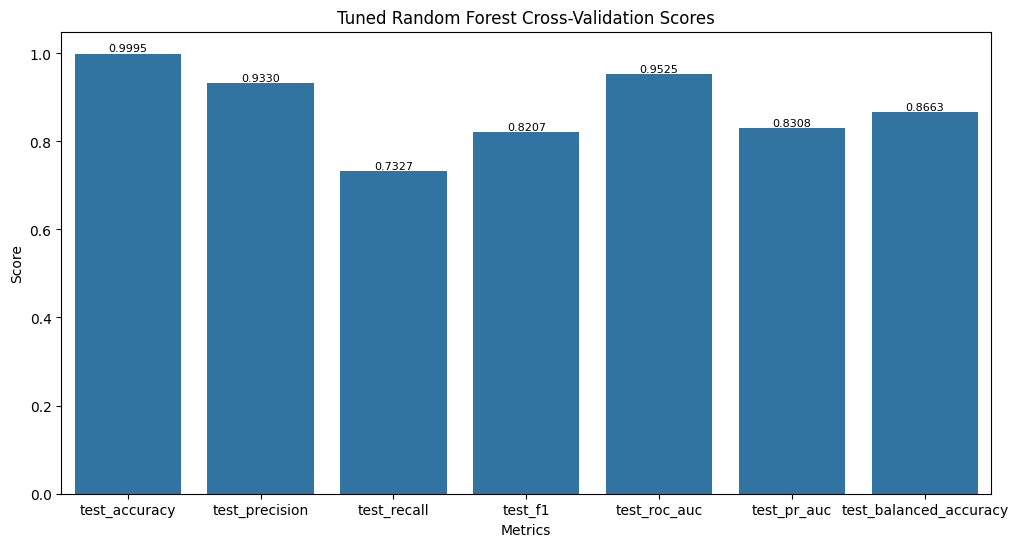

In [ ]:
plt.figure(figsize=(12, 6))

# 📊 Bar plot for Random Forest metrics
rf_tuned_scores_barplot = sns.barplot(data=tuned_rf_results.loc['test_accuracy':])

# Annotate bars with their values
for patch in rf_tuned_scores_barplot.patches:
    height = patch.get_height()
    rf_tuned_scores_barplot.annotate(
        f'{height:.4f}',  # Format value
        (patch.get_x() + patch.get_width() / 2, height),  # Center annotation
        ha='center', va='bottom', fontsize=8, color='black'
    )

plt.title("Tuned Random Forest Cross-Validation Scores")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.show()

### Now that we have found the best hyperparameters, lets train our *final* model on the whole training data

In [ ]:
final_rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    max_features='sqrt',
    max_depth=None,
    random_state=11037,
    class_weight='balanced',
    n_jobs=-1,
)

In [ ]:
# train the model on the training data
final_rf_model.fit(X_train,y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
filename = Path.cwd().parent / 'models' / 'final_rf_model.pkl'
final_rf_model = joblib.load(filename=filename)

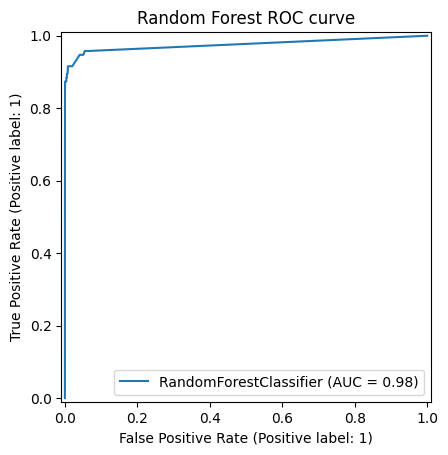

In [ ]:
RocCurveDisplay.from_estimator(final_rf_model, X_test, y_test)
plt.title('Random Forest ROC curve')
plt.show()

[[56646     5]
 [   23    72]]


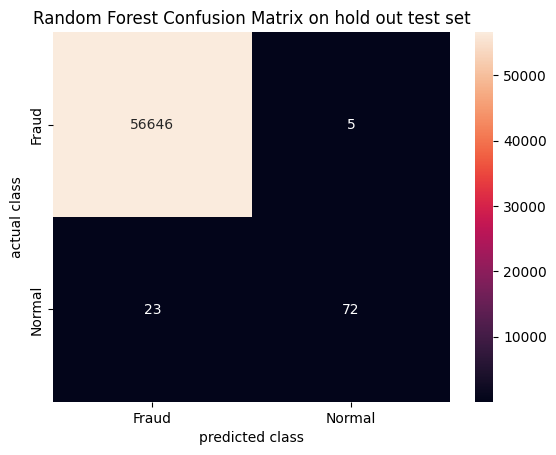

In [ ]:
y_pred = final_rf_model.predict(X_test)
def plot_confusion_matrix( y_pred: pd.DataFrame, y_test: pd.DataFrame, title: str):
    final_model_cm = confusion_matrix(y_test,y_pred)
    labels = ['Fraud', 'Normal']

    sns.heatmap(final_model_cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('predicted class')
    plt.ylabel('actual class')
    print(final_model_cm)

plot_confusion_matrix(y_pred, y_test, 'Random Forest Confusion Matrix on hold out test set')

In [ ]:
scoring_call = check_scoring(estimator=final_rf_model, scoring=scoring, raise_exc=False)
scores = scoring_call(final_rf_model, X_test, y_test)

In [ ]:
scores = pd.Series(scores)

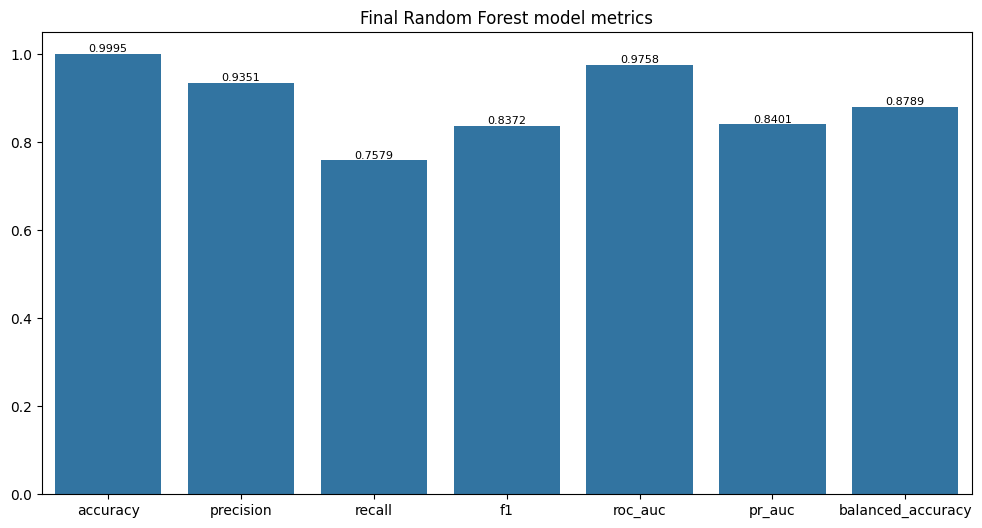

In [ ]:
plot_bar_metrics(scores, 'Final Random Forest model metrics')

### finally, saving the final model using joblib

In [ ]:
Path.cwd()

WindowsPath('e:/Programacao/LAPES/EDA_ML_DL_PS/LAPES-Data-Challenge-Predictive-Analytics-System/notebooks')

In [ ]:

file_path = Path.cwd().parent / 'models' / 'final_rf_model.pkl'
joblib.dump(final_rf_model, file_path)

print('model succesfully saved in', file_path)

model succesfully saved in e:\Programacao\LAPES\EDA_ML_DL_PS\LAPES-Data-Challenge-Predictive-Analytics-System\models\final_rf_model.pkl


In [ ]:
filepath_rf = Path.cwd().parent / 'models' / 'final_rf_model.pkl'
filepath_bst = Path.cwd().parent / 'models' / 'final_XGBoost_model.pkl'
filepath_log = Path.cwd().parent / 'models' / 'logistic_regression_baseline.pkl'

log_clf = joblib.load(filepath_log)
bst_clf = joblib.load(filepath_bst)
final_rf_model = joblib.load(filepath_rf)

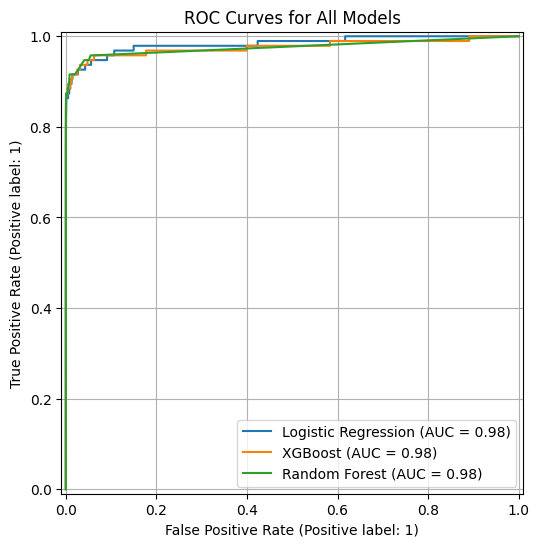

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))


RocCurveDisplay.from_estimator(log_clf, X_test, y_test, ax=ax, name="Logistic Regression")

RocCurveDisplay.from_estimator(bst_clf, X_test, y_test, ax=ax, name="XGBoost")

RocCurveDisplay.from_estimator(final_rf_model, X_test, y_test, ax=ax, name="Random Forest")

ax.set_title("ROC Curves for All Models")
ax.grid(True)

plt.show()
